# MIGHT example on Wise-1 cancer data

## Import libraries and local functions

In [3]:
# dependency libararies
import warnings
import pickle
import time
import numpy as np
import pandas as pd

# treeple functions
from treeple.ensemble import HonestForestClassifier
from treeple.tree import ObliqueDecisionTreeClassifier
from treeple.stats import build_oob_forest

warnings.filterwarnings("ignore")

In [4]:
# local function for processing cancer data files
def get_X_y(f, root="./data/", cohort=[], verbose=False):
    df = pd.read_csv(root + f)
    non_features = [
        "Run",
        "Sample",
        "Library",
        "Cancer Status",
        "Tumor type",
        "Stage",
        "Library volume (uL)",
        "Library Volume",
        "UIDs Used",
        "Experiment",
        "P7",
        "P7 Primer",
        "MAF",
    ]
    sample_ids = df["Sample"]
    # if sample is contains "Run" column, remove it
    for i, sample_id in enumerate(sample_ids):
        if "." in sample_id:
            sample_ids[i] = sample_id.split(".")[1]
    target = "Cancer Status"
    y = df[target]
    # convert the labels to 0 and 1
    y = y.replace("Healthy", 0)
    y = y.replace("Cancer", 1)
    # remove the non-feature columns if they exist
    for col in non_features:
        if col in df.columns:
            df = df.drop(col, axis=1)
    nan_cols = df.isnull().all(axis=0).to_numpy()
    # drop the columns with all nan values
    df = df.loc[:, ~nan_cols]
    # if cohort is not None, filter the samples
    if cohort is not None:
        # filter the rows with cohort1 samples
        X = df[sample_ids.isin(cohort)]
        y = y[sample_ids.isin(cohort)]
    else:
        X = df
    if "Wise" in f:
        # replace nans with zero
        X = X.fillna(0)
    # impute the nan values with the mean of the column
    X = X.fillna(X.mean(axis=0))
    # check if there are nan values
    # nan_rows = X.isnull().any(axis=1)
    nan_cols = X.isnull().all(axis=0)
    # remove the columns with all nan values
    X = X.loc[:, ~nan_cols]
    if verbose:
        if nan_cols.sum() > 0:
            print(f)
            print(f"nan_cols: {nan_cols.sum()}")
            print(f"X shape: {X.shape}, y shape: {y.shape}")
        else:
            print(f)
            print(f"X shape: {X.shape}, y shape: {y.shape}")
    # X = X.dropna()
    # y = y.drop(nan_rows.index)

    return X, y

## Process the Wise-1 cancer data

In [5]:
DIRECTORY = "./"
N_JOBS = 4
N_EST = 100 # 100_000

# collect sample data
sample_list_file = DIRECTORY + "AllSamples.MIGHT.Passed.samples.txt"
sample_list = pd.read_csv(sample_list_file, sep=" ", header=None)
sample_list.columns = ["library", "sample_id", "cohort"]

# get the sample ids for specific cohorts
cohort1 = sample_list[sample_list["cohort"] == "Cohort1"]["sample_id"]
cohort2 = sample_list[sample_list["cohort"] == "Cohort2"]["sample_id"]
PON = sample_list[sample_list["cohort"] == "PanelOfNormals"]["sample_id"]

In [6]:
# obtain the samples for cohort 1
X, y = get_X_y("WiseCondorX.Wise-1.csv.gz", root=DIRECTORY, cohort=cohort1)

# Save the processed data to a CSV file for use in the Yggdrasil notebook
processed_data = X.copy()
processed_data["Cancer Status"] = y
processed_data.to_csv("processed_wise1_data.csv", index=False)

In [7]:
X, y

(      1:1000001-2000000  1:3000001-4000000  1:4000001-5000000  \
 1              0.225947           1.416049          -2.179124   
 2             -2.667007          -1.786801          -2.033666   
 3             -1.710259           0.548870           2.259227   
 4             -0.647132           0.947723           0.708668   
 5             -0.556629          -0.265036          -1.387337   
 ...                 ...                ...                ...   
 1977          -1.033230          -0.481271          -0.151797   
 1978           0.334699           0.418391           0.259319   
 1979          -1.158377          -0.151177           1.849532   
 1980           0.346247           1.272352          -0.874088   
 1981          -2.568370           0.739229           0.001433   
 
       1:5000001-6000000  1:6000001-7000000  1:7000001-8000000  \
 1             -1.393526           0.713901           0.336313   
 2             -2.059203          -2.588441          -2.345855   
 3      

In [8]:
X.shape

(352, 2523)

## Run axis-aligned MIGHT

## Run axis-aligned MIGHT

In [9]:
est = HonestForestClassifier(
    n_estimators=N_EST,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=N_JOBS,
    random_state=23,
    honest_prior="ignore",
    honest_method='prune',
)

# record start time
start_time = time.perf_counter()

# obtain tree level posteriors
fitted_est, tree_proba = build_oob_forest(est, X, y)

# calculate fitting time
end_time = time.perf_counter()
time_dif = end_time-start_time

print(time_dif)

1.2532977919981931


In [10]:
# obtain forest level posteriors
forest_proba = np.nanmean(tree_proba, axis=0)

## Or run oblique MIGHT

In [11]:
est = HonestForestClassifier(
    n_estimators=N_EST,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=N_JOBS,
    random_state=23,
    honest_prior="ignore",
    honest_method='prune',
    tree_estimator=ObliqueDecisionTreeClassifier(),
)

# record start time
start_time = time.perf_counter()

# obtain tree level posteriors
fitted_est, tree_proba = build_oob_forest(est, X, y)

# calculate fitting time
end_time = time.perf_counter()
time_dif = end_time-start_time

print(time_dif)

4.578075041001284


In [12]:
# obtain forest level posteriors
forest_proba = np.nanmean(tree_proba, axis=0)

In [20]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suppose you previously loaded `processed_data = X.copy()`
# processed_data["Cancer Status"] = y
df = pd.read_csv("processed_wise1_data.csv")

LABEL_COL = "Cancer Status"
X = df.drop(columns=[LABEL_COL])
y = df[LABEL_COL]

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=y)

# Rebuild X_train, y_train for MIGHT
X_train = train_df.drop(columns=[LABEL_COL])
y_train = train_df[LABEL_COL]
X_test = test_df.drop(columns=[LABEL_COL])
y_test = test_df[LABEL_COL]


est = HonestForestClassifier(
    n_estimators=N_EST,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=N_JOBS,
    random_state=23,
    honest_prior="ignore",
    honest_method='prune',
    # tree_estimator=ObliqueDecisionTreeClassifier()
)

# Train on X_train, y_train
start_time = time.perf_counter()
fitted_est, tree_proba = build_oob_forest(est, X_train, y_train)
end_time = time.perf_counter()
train_time = end_time - start_time
print(f"\nMIGHT model trained in {train_time:.2f} seconds on {len(X_train)} examples.")

# Evaluate on X_test
# MIGHT doesn't have built-in evaluate on new data, but you can do manual predictions:
test_tree_proba = []
for tree in fitted_est.estimators_:
    # predict_proba for each tree
    test_tree_proba.append(tree.predict_proba(X_test))

test_tree_proba = np.stack(test_tree_proba, axis=0)  # shape: (n_estimators, n_test, 2)
avg_proba = test_tree_proba.mean(axis=0)  # shape: (n_test, 2)
y_proba_test = avg_proba[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
cls_rpt_test = classification_report(y_test, y_pred_test)

print("\n=== MIGHT Evaluation on Test Set ===")
print(f"Accuracy: {acc_test:.3f}")
print("Confusion matrix:\n", cm_test)
print("\nClassification Report:\n", cls_rpt_test)

# Print sample probabilities
print("\nSample predicted probabilities (first 10):")
print(y_proba_test[:10])


MIGHT model trained in 0.69 seconds on 246 examples.

=== MIGHT Evaluation on Test Set ===
Accuracy: 0.377
Confusion matrix:
 [[28 47]
 [19 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.37      0.46        75
           1       0.20      0.39      0.27        31

    accuracy                           0.38       106
   macro avg       0.40      0.38      0.36       106
weighted avg       0.48      0.38      0.40       106


Sample predicted probabilities (first 10):
[  nan 15.92   nan 19.26   nan 17.68 14.52   nan   nan 16.69]


In [ ]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suppose you previously loaded `processed_data = X.copy()`
# processed_data["Cancer Status"] = y
df = pd.read_csv("processed_wise1_data.csv")

LABEL_COL = "Cancer Status"
X = df.drop(columns=[LABEL_COL])
y = df[LABEL_COL]

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=y)

# Rebuild X_train, y_train for MIGHT
X_train = train_df.drop(columns=[LABEL_COL])
y_train = train_df[LABEL_COL]
X_test = test_df.drop(columns=[LABEL_COL])
y_test = test_df[LABEL_COL]


est = HonestForestClassifier(
    n_estimators=N_EST,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=N_JOBS,
    random_state=23,
    honest_prior="ignore",
    honest_method='prune',
    tree_estimator=ObliqueDecisionTreeClassifier()
)

# Train on X_train, y_train
start_time = time.perf_counter()
fitted_est, tree_proba = build_oob_forest(est, X_train, y_train)
end_time = time.perf_counter()
train_time = end_time - start_time
print(f"\nMIGHT model trained in {train_time:.2f} seconds on {len(X_train)} examples.")

# Evaluate on X_test
# MIGHT doesn't have built-in evaluate on new data, but you can do manual predictions:
test_tree_proba = []
for tree in fitted_est.estimators_:
    # predict_proba for each tree
    test_tree_proba.append(tree.predict_proba(X_test))

test_tree_proba = np.stack(test_tree_proba, axis=0)  # shape: (n_estimators, n_test, 2)
avg_proba = test_tree_proba.mean(axis=0)  # shape: (n_test, 2)
y_proba_test = avg_proba[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
cls_rpt_test = classification_report(y_test, y_pred_test)

print("\n=== MIGHT Evaluation on Test Set ===")
print(f"Accuracy: {acc_test:.3f}")
print("Confusion matrix:\n", cm_test)
print("\nClassification Report:\n", cls_rpt_test)

# Print sample probabilities
print("\nSample predicted probabilities (first 10):")
print(y_proba_test[:10])


MIGHT model trained in 3.00 seconds on 246 examples.

=== MIGHT Evaluation on Test Set ===
Accuracy: 0.538
Confusion matrix:
 [[44 31]
 [18 13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.59      0.64        75
           1       0.30      0.42      0.35        31

    accuracy                           0.54       106
   macro avg       0.50      0.50      0.49       106
weighted avg       0.59      0.54      0.56       106


Sample predicted probabilities (first 10):
[35.62   nan   nan   nan   nan   nan   nan   nan   nan   nan]


## Benchmarks


(n=125, d=10) after 7 repeats:
  train_time mean=0.1625s std=0.0134
  inference_time mean=0.0127s std=0.0002
  accuracy mean=0.459 std=0.058

(n=125, d=20) after 7 repeats:
  train_time mean=0.1580s std=0.0071
  inference_time mean=0.0139s std=0.0004
  accuracy mean=0.519 std=0.036

(n=125, d=40) after 7 repeats:
  train_time mean=0.1518s std=0.0034
  inference_time mean=0.0157s std=0.0004
  accuracy mean=0.492 std=0.054

(n=125, d=80) after 7 repeats:
  train_time mean=0.1506s std=0.0037
  inference_time mean=0.0193s std=0.0006
  accuracy mean=0.481 std=0.048

(n=250, d=10) after 7 repeats:
  train_time mean=0.1863s std=0.0045
  inference_time mean=0.0127s std=0.0002
  accuracy mean=0.493 std=0.056

(n=250, d=20) after 7 repeats:
  train_time mean=0.1845s std=0.0037
  inference_time mean=0.0136s std=0.0003
  accuracy mean=0.495 std=0.033

(n=250, d=40) after 7 repeats:
  train_time mean=0.1865s std=0.0036
  inference_time mean=0.0157s std=0.0002
  accuracy mean=0.455 std=0.052

(n=25

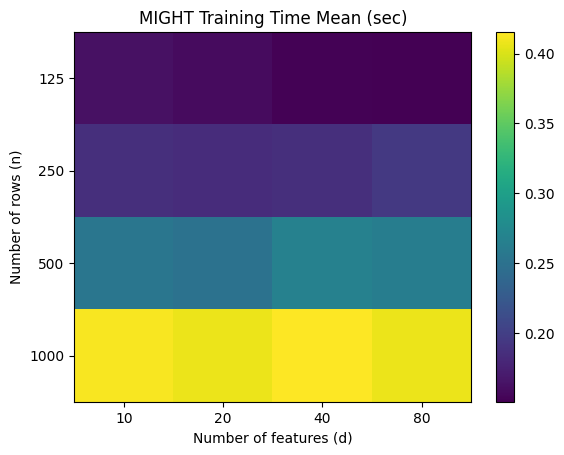

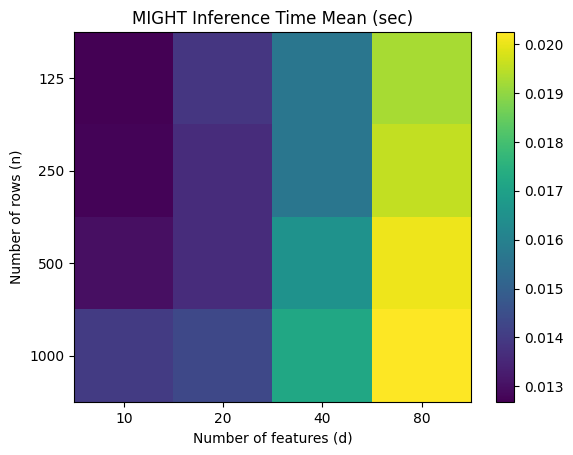

In [26]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# MIGHT / treeple
from treeple.ensemble import HonestForestClassifier
from treeple.tree import ObliqueDecisionTreeClassifier
from treeple.stats import build_oob_forest

def benchmark_might(n_vals, d_vals, repeats=7, random_seed=42):
    """
    Benchmarks MIGHT's training & inference time across multiple (n, d) data sizes,
    repeating each (n,d) experiment `repeats` times to compute mean & std dev.

    :param n_vals: List of row counts to test, e.g. [125, 250, 500, 1000, 2000, 4000, 8000]
    :param d_vals: List of feature counts to test, e.g. [10, 20, 40, 80, 160, 320]
    :param repeats: Number of times to repeat each (n,d) scenario for averaging
    :param random_seed: random seed for reproducible data generation
    :return: A DataFrame with columns:
             ["n", "d",
              "train_time_mean", "train_time_std",
              "inference_time_mean", "inference_time_std",
              "accuracy_mean", "accuracy_std"]
    """
    np.random.seed(random_seed)
    results = []

    for n in n_vals:
        for d in d_vals:

            train_times = []
            inference_times = []
            accuracies = []

            for rep in range(repeats):
                # 1) Generate random data
                X = np.random.randn(n, d)  # NxD standard normal
                y = np.random.randint(2, size=n)  # binary labels 0 or 1

                # 2) Train/test split
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=random_seed, stratify=y
                )

                # 3) Convert to DataFrame for MIGHT
                df_train = pd.DataFrame(X_train)
                df_test  = pd.DataFrame(X_test)

                # 4) Build classifier
                #    You can adjust n_estimators for heavier or lighter benchmark.
                est = HonestForestClassifier(
                    n_estimators=50,
                    max_samples=1.0,
                    max_features=0.3,
                    bootstrap=True,
                    stratify=True,
                    n_jobs=-1,
                    random_state=random_seed,
                    honest_prior="ignore",
                    honest_method="prune",
                    tree_estimator=ObliqueDecisionTreeClassifier()
                )

                # 5) Training time
                t0 = time.perf_counter()
                fitted_est, tree_proba = build_oob_forest(est, df_train, y_train)
                t1 = time.perf_counter()
                train_time = t1 - t0

                # 6) Inference time: average probabilities across trees
                t2 = time.perf_counter()
                test_tree_proba = []
                for tree in fitted_est.estimators_:
                    p = tree.predict_proba(df_test)  # shape (n_test, 2)
                    test_tree_proba.append(p)
                test_tree_proba = np.stack(test_tree_proba, axis=0)  # (n_estimators, n_test, 2)
                avg_proba = test_tree_proba.mean(axis=0)  # (n_test, 2)
                y_proba_test = avg_proba[:, 1]
                y_pred_test = (y_proba_test >= 0.5).astype(int)
                t3 = time.perf_counter()
                inference_time = t3 - t2

                # 7) Accuracy
                acc = accuracy_score(y_test, y_pred_test)

                train_times.append(train_time)
                inference_times.append(inference_time)
                accuracies.append(acc)

            # Compute mean/std across `repeats`
            train_time_mean = np.mean(train_times)
            train_time_std  = np.std(train_times)
            inf_time_mean   = np.mean(inference_times)
            inf_time_std    = np.std(inference_times)
            acc_mean        = np.mean(accuracies)
            acc_std         = np.std(accuracies)

            print(f"\n(n={n}, d={d}) after {repeats} repeats:")
            print(f"  train_time mean={train_time_mean:.4f}s std={train_time_std:.4f}")
            print(f"  inference_time mean={inf_time_mean:.4f}s std={inf_time_std:.4f}")
            print(f"  accuracy mean={acc_mean:.3f} std={acc_std:.3f}")

            results.append({
                "n": n,
                "d": d,
                "train_time_mean": train_time_mean,
                "train_time_std": train_time_std,
                "inference_time_mean": inf_time_mean,
                "inference_time_std": inf_time_std,
                "accuracy_mean": acc_mean,
                "accuracy_std": acc_std
            })

    return pd.DataFrame(results)


if __name__ == "__main__":
    # 1) Ranges of (n, d)
    n_values = [125, 250, 500, 1000]
    d_values = [10, 20, 40, 80]

    # 2) Run the benchmark with repeats
    df_bench = benchmark_might(n_values, d_values, repeats=7, random_seed=42)

    print("\n=== MIGHT Benchmark Results (Averaged Over Repeats) ===")
    print(df_bench)

    # Build pivot tables for training time means
    pivot_train = df_bench.pivot(index="n", columns="d", values="train_time_mean")
    pivot_infer = df_bench.pivot(index="n", columns="d", values="inference_time_mean")

    ###################################
    # 3) Plot Heatmap for Training Time
    ###################################
    plt.figure()
    plt.imshow(pivot_train, aspect="auto")
    plt.colorbar()
    plt.title("MIGHT Training Time Mean (sec)")
    plt.xticks(ticks=range(len(d_values)), labels=d_values)
    plt.yticks(ticks=range(len(n_values)), labels=n_values)
    plt.xlabel("Number of features (d)")
    plt.ylabel("Number of rows (n)")
    plt.show()

    ####################################
    # 4) Plot Heatmap for Inference Time
    ####################################
    plt.figure()
    plt.imshow(pivot_infer, aspect="auto")
    plt.colorbar()
    plt.title("MIGHT Inference Time Mean (sec)")
    plt.xticks(ticks=range(len(d_values)), labels=d_values)
    plt.yticks(ticks=range(len(n_values)), labels=n_values)
    plt.xlabel("Number of features (d)")
    plt.ylabel("Number of rows (n)")
    plt.show()